In [1]:
# Essential Imports
import numpy as np
import torch
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

In [15]:
# Local imports
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files

from scnn import SNN, SpikingDenseLayer, SpikingConv2DLayer, SpikingConv3DLayer
from scnn.heaviside import SurrogateHeaviside

from scnn.optim import RAdam

In [3]:
# Tools Import
from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
te = TimeExpector()

def print_progress(msg, value, width=80, a='=', b='>', c='.'):
    print('\r%s [%s%s%s] %d%%' % (msg, a*int(value*width), b, c*int((1.-value)*width), value*100), end='')

In [4]:
batch_size = 16
nb_epochs = 20

In [5]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

using cpu...


In [6]:
# FIXME
my_laptop = False
if my_laptop:
    CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
    DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"
else:
    CACHE_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"
    DATASET_FOLDER_PATH = "/home/aref/dataset/dvs-dataset"

    
def load_data(trail):
    trail = 'acc_test'
    
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=20
    )

# calculate train dataset size
dataset_size = 0.
for x_batch, y_batch in load_data('train'):
    dataset_size += 1.
    if dataset_size % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size, end='')
print('\rpre-processing dataset: %d' % dataset_size)

pre-processing dataset: 137


In [61]:
%matplotlib inline

from matplotlib.gridspec import GridSpec

def plot_spikes_in_time(layer, batch_id=0):
    if layer.IS_CONV:
        _plot_spikes_conv(layer, batch_id)
    else:
        _plot_spikes_dense(layer, batch_id)


def _plot_spikes_dense(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    for i in range(mem_rec_hist.shape[1]):
        plt.plot(mem_rec_hist[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    
    plt.show()
    plt.plot(spk_rec_hist,'b.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(spk_rec_hist)
    plt.xlabel('Neuron')
    plt.ylabel('Spike Time')
    plt.axis([-1, spk_rec_hist.shape[1], -1, spk_rec_hist.shape[0]])
    plt.show()
    

def _plot_spikes_conv(layer, batch_id=0):
    spk_rec_hist = layer.spk_rec_hist[batch_id]
    mem_rec_hist = layer.mem_rec_hist[batch_id]
    
    time_step = mem_rec_hist.shape[0]
    flat_spk = np.reshape(spk_rec_hist, (time_step, np.prod(mem_rec_hist.shape[1:])))
    flat_mem = np.reshape(mem_rec_hist, (time_step, np.prod(mem_rec_hist.shape[1:])))
    
    # Plot Flats
    max_flats = 25
    if flat_mem.shape[1] > max_flats:
        inx = np.random.randint(flat_mem.shape[1], size=max_flats)
        flat_spk = flat_spk[:, inx]
        flat_mem = flat_mem[:, inx]
    
    for i in range(flat_mem.shape[1]):
        plt.plot(flat_mem[:, i], label='mem')
    plt.xlabel('Time')
    plt.ylabel('Membrace Potential')
    plt.show()
    
    plt.plot(flat_spk,'.')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.show()
    
    plt.matshow(flat_spk, cmap=plt.cm.gray_r, origin="lower", aspect='auto')
    plt.xlabel('Neuron')
    plt.ylabel ('Spike Time')
    plt.axis([-1, flat_spk.shape[1], -1, flat_spk.shape[0]])
    plt.show()
    
    # Visual Plots
    max_visual = 5
    
#     debug_print(spk_rec_hist, 'spk', pytorch=False)
#     debug_print(mem_rec_hist, 'mem', pytorch=False)

    time_idx = list(range(0, time_step, int(time_step/max_visual)))
    neur_idx = np.random.randint(mem_rec_hist.shape[1], size=max_visual)

    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

#     counter = 0
#     for n in neur_idx:
#         for t in time_idx:
#             if counter == 0:
#                 a0 = ax = plt.subplot(gs[counter])
#             else:
#                 ax = plt.subplot(gs[counter], sharey=a0)
#             ax.imshow(spk_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
#             plt.title('t(%d) - n(%d)' % (t, n))
#             counter += 1
#     plt.show()
    
    gs = GridSpec(max_visual, max_visual)
    plt.figure(figsize=(30, 20))

    counter = 0
    for n in neur_idx:
        for t in time_idx:
            if counter == 0:
                a0 = ax = plt.subplot(gs[counter])
            else:
                ax = plt.subplot(gs[counter], sharey=a0)
            ax.imshow(mem_rec_hist[t, n, :, :], cmap=plt.cm.gray_r, origin="lower", aspect='auto')
            plt.title('t(%d) - n(%d)' % (t, n))
            counter += 1

In [8]:
def debug_print(val, name, show_data=False, pytorch=True):
    print('%s' % name, val.shape)
    if show_data:
        print(val)
    if pytorch:
        print('min=%.2f | mean=%.2f | max=%.2f' % (torch.min(val), torch.mean(val), torch.max(val)))
    else:
        print('min=%.2f | mean=%.2f | max=%.2f' % (np.min(val), np.mean(val), np.max(val)))
    print('\n---------------------------------------------------------------\n')

In [45]:
import torch
import numpy as np
from scnn.default_configs import *


class SimpleSpike(torch.nn.Module):
    IS_CONV = False
    IS_SPIKING = True

    def __init__(self, input_shape, output_shape, spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD,
                 recurrent=False, lateral_connections=True, eps=EPSILON):
        super(SimpleSpike, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.eps = eps
        self.lateral_connections = lateral_connections

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_shape, output_shape)), requires_grad=True)

#         self.alpha = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        tau_mem = 10e-3
        tau_syn = 5e-3
        time_step = 1e-3

        self._alpha   = float(np.exp(-time_step/tau_syn))
        self._beta    = float(np.exp(-time_step/tau_mem))

        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()
        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

    def forward(self, x):
        batch_size = x.shape[0]
        nb_steps = x.shape[1]

        h1 = torch.einsum("abc,cd->abd", (x, self.w))
        syn = torch.zeros((batch_size, self.output_shape), device=device, dtype=dtype)
        mem = torch.zeros((batch_size, self.output_shape), device=device, dtype=dtype)
        
        spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
        mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
        
        # Compute hidden layer activity
        for t in range(nb_steps):
            mthr = mem - 1.0
            out = self.spike_fn(mthr)
            rst = torch.zeros_like(mem)
            c   = (mthr > 0)
            rst[c] = torch.ones_like(mem)[c]

            new_syn = self._alpha * syn + h1[:, t]
            new_mem = self._beta * mem + syn - rst

            mem = new_mem
            syn = new_syn

            mem_rec[:, t, :] = mem
            spk_rec[:, t, :] = out

        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = mem_rec.detach().cpu().numpy()
        loss = 0.5 * (spk_rec ** 2).mean()
        return spk_rec, loss
        

#         for t in range(nb_steps):
#             # reset term
#             if self.lateral_connections:
#                 rst = torch.einsum("ab,bc ->ac", spk, d)
#             else:
#                 rst = spk * self.b * norm

#             input_ = h[:, t, :]
#             if self.recurrent:
#                 input_ = input_ + torch.einsum("ab,bc->ac", spk, self.v)

#             # membrane potential update
#             mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
#             mthr = torch.einsum("ab,b->ab", mem, 1. / (norm + self.eps)) - self.b

#             print('mthr', mthr)
#             spk = self.spike_fn(mthr)
#             print('spk', spk)

#             spk_rec[:, t, :] = spk
#             self.mem_rec_hist[:, t, :] = mem

#             # save spk_rec for plotting
#         self.spk_rec_hist = spk_rec.detach().cpu().numpy()
#         self.mem_rec_hist = self.mem_rec_hist.detach().cpu().numpy()
#         loss = 0.5 * (spk_rec ** 2).mean()
#         return spk_rec, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))
#         if self.recurrent:
#             torch.nn.init.normal_(self.v, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.output_shape))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
#         torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        pass
        self.beta.data.clamp_(0., 1.)
#         self.b.data.clamp_(min=0.)



In [58]:
class NewSpiker(torch.nn.Module):
    IS_CONV = False
    IS_SPIKING = True

    def __init__(self, input_shape, output_shape, spike_fn, w_init_mean=W_INIT_MEAN, w_init_std=W_INIT_STD,
                 recurrent=False, lateral_connections=True, eps=EPSILON):
        super(NewSpiker, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.spike_fn = spike_fn
        self.recurrent = recurrent
        self.eps = eps
        self.lateral_connections = lateral_connections

        self.w_init_mean = w_init_mean
        self.w_init_std = w_init_std

        self.w = torch.nn.Parameter(torch.empty((input_shape, output_shape)), requires_grad=True)
        if recurrent:
            self.v = torch.nn.Parameter(torch.empty((output_shape, output_shape)), requires_grad=True)

        self.beta = torch.nn.Parameter(torch.empty(1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.empty(output_shape), requires_grad=True)

        self.reset_parameters()
        self.clamp()
        self.spk_rec_hist = None
        self.mem_rec_hist = None
        self.training = True

    def forward(self, x):
        batch_size = x.shape[0]

        h = torch.einsum("abc,cd->abd", x, self.w)
        nb_steps = h.shape[1]

        # membrane potential 
        mem = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)
        # output spikes
        spk = torch.zeros((batch_size, self.output_shape), dtype=x.dtype, device=x.device)

        # output spikes recording
        spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
        self.mem_rec_hist = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

        if self.lateral_connections:
            d = torch.einsum("ab, ac -> bc", self.w, self.w)

        norm = (self.w ** 2).sum(0)

        for t in range(nb_steps):
            # reset term
            if self.lateral_connections:
                rst = torch.einsum("ab,bc ->ac", spk, d)
            else:
                rst = spk * self.b * norm

            input_ = h[:, t, :]
            if self.recurrent:
                input_ = input_ + torch.einsum("ab,bc->ac", spk, self.v)

            # membrane potential update
            mem = (mem - rst) * self.beta + input_ * (1. - self.beta)
            mthr = torch.einsum("ab,b->ab", mem, 1. / (norm + self.eps)) - self.b

            spk = self.spike_fn(mthr)

            spk_rec[:, t, :] = spk
            self.mem_rec_hist[:, t, :] = mem

            # save spk_rec for plotting
        self.spk_rec_hist = spk_rec.detach().cpu().numpy()
        self.mem_rec_hist = self.mem_rec_hist.detach().cpu().numpy()
        loss = 0.5 * (spk_rec ** 2).mean()
        return spk_rec, loss

    def reset_parameters(self):
        torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))
        if self.recurrent:
            torch.nn.init.normal_(self.v, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.output_shape))
        torch.nn.init.normal_(self.beta, mean=0.7, std=0.01)
        torch.nn.init.normal_(self.b, mean=1., std=0.01)

    def clamp(self):
        self.beta.data.clamp_(0., 1.)
        self.b.data.clamp_(min=0.)



In [59]:
network = SNN().to(device, dtype)


tau_mem = 10e-3
tau_syn = 5e-3
time_step = 1e-3
beta = float(np.exp(-time_step / tau_mem))
weight_scale = 7*(1.0 - beta)


network.add_layer(NewSpiker,
    input_shape=4096,
    output_shape=128,
                  
    w_init_mean=0.0,
    w_init_std=weight_scale
)

# network.add_conv3d(input_shape=(64,64),
#                    output_shape=(64,64),
#                    input_channels=1,
#                    output_channels=32,
#                    kernel_size=(1,3,3),
#                    dilation=(1,1,1),
#                    lateral_connections=False,
# )


# network.add_dense(
#     input_shape=4096,
#     output_shape=256,
#    w_init_mean=0.006,
# #     w_init_std=.96,
#     lateral_connections=True
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=256
# )

# network.add_layer(SpikingDenseLayer,
#     output_shape=128,
#     w_init_mean=.19
# )

network.add_readout(output_shape=12,
                    time_reduction="max" # mean or max
)

network.compile()

x shape= torch.Size([16, 20, 4096])
Layer 0: average number of spikes=0.0000
spk (20, 128)
min=0.00 | mean=0.00 | max=0.00

---------------------------------------------------------------

mem (20, 128)
min=-0.53 | mean=-0.01 | max=0.39

---------------------------------------------------------------



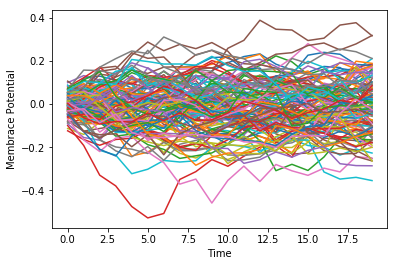

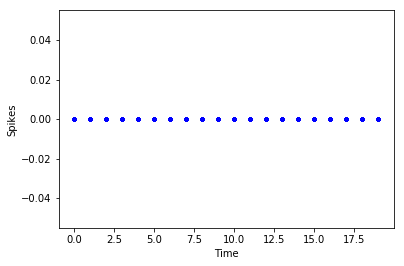

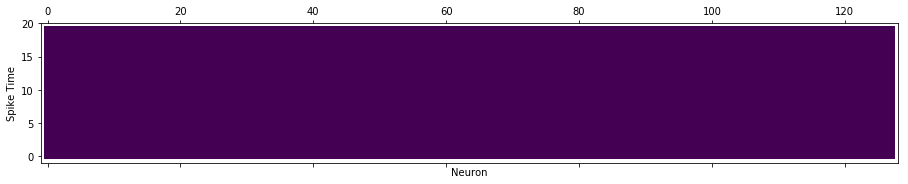

In [60]:
for X_batch, _ in load_data('train'):
    break
    
shp = X_batch.shape

if network.layers[0].IS_CONV:
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
else:
    X_batch = np.reshape(X_batch, [shp[0], shp[1], shp[2] * shp[3]])

X_batch = torch.from_numpy(X_batch).to(device, dtype)
print('x shape=', X_batch.shape)

network(X_batch)

# plot_counter = 0
for i,l in enumerate(network.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SimpleSpike) or isinstance(l, NewSpiker) or \
       isinstance(l, SpikingConv2DLayer) or \
       isinstance(l, SpikingConv3DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i, l.spk_rec_hist.mean()))
        plot_spikes_in_time(l)

In [ ]:
nb_plt = min(batch_size, 9)

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(network.layers):
#     print('layer', i)
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    elif isinstance(l, SpikingConv3DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1).sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [62]:
def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= 1000*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        te.tick(nb_epochs-e)
        print('\n')
        local_loss = []
#         reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        #with tqdm_notebook(total=len(train_dataloader)) as pb:
        e_2 = 0
        for x_batch, y_batch in load_data('train'):
            e_2 += 1
            print_progress('Epoch: %d' % e, e_2/dataset_size)
            #print('\r%d -- %d' % (e, e_2), end='')
            shp = x_batch.shape
            if model.layers[0].IS_CONV:
                x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
            else:
                x_batch = np.reshape(x_batch, [shp[0], shp[1], shp[2] * shp[3]])
        
        
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)

#             print('a')
            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

#             print('b')
#             for i,loss in enumerate(loss_seq[:-1]):
#                 print('  -', i)
#                 reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
#                 loss_val += reg_loss_val
#                 reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()
            
            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("  |  loss=%.5f"%(mean_loss))
        
#         for i,loss in enumerate(reg_loss):
#             mean_reg_loss = np.mean(loss)
#             print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(network.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, 'test')
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        te.tock()
        
    return hist
        
def compute_classification_accuracy(model, trail):
    accs = []
    
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in load_data(trail):
            shp = x_batch.shape
            if model.layers[0].IS_CONV:
                x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
            else:
                x_batch = np.reshape(x_batch, [shp[0], shp[1], shp[2] * shp[3]])
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
    return np.mean(accs)

In [63]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(network.layers)]
params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(network.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(network.layers)]
if network.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(network.layers[:-1])]
elif network.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(network.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(network, params, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)

test_accuracy = compute_classification_accuracy(network, 'test')
print("Test accuracy=%.3f"%(test_accuracy))
test_accuracy = compute_classification_accuracy(network , 'train')
print("Test accuracy=%.3f"%(test_accuracy))

[expecting to finish at 2020-04-03 18:01:23]


Epoch: 0 [================================================================================>] 100%  |  loss=2.48432
Layer 0: average number of spikes=0.0007
Validation accuracy=0.089
[operation finished at 2020-04-03 17:57:20  -  took 15 seconds]
[expecting to finish at 2020-04-03 18:01:30]


Epoch: 1 [================================================================================>] 100%  |  loss=2.44774
Layer 0: average number of spikes=0.0422
Validation accuracy=0.321
[operation finished at 2020-04-03 17:57:36  -  took 15 seconds]
[expecting to finish at 2020-04-03 18:01:38]


Epoch: 2 [================================================================================>] 100%  |  loss=2.34691
Layer 0: average number of spikes=0.0914
Validation accuracy=0.347
[operation finished at 2020-04-03 17:57:52  -  took 15 seconds]
[expecting to finish at 2020-04-03 18:01:45]


Epoch: 3 [================================================================

x shape= torch.Size([16, 20, 4096])
Layer 0: average number of spikes=0.1783


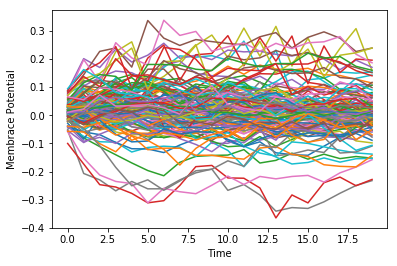

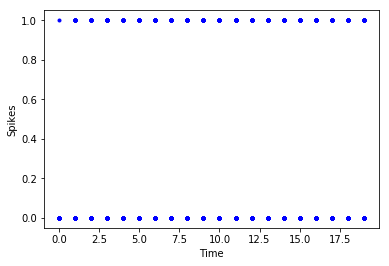

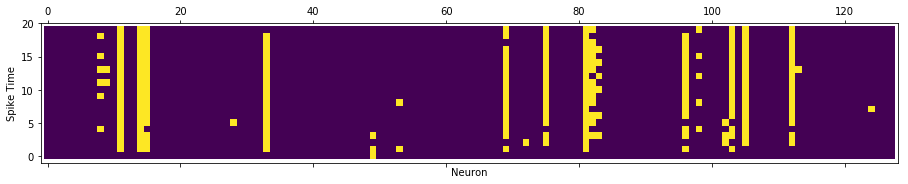

In [64]:
for X_batch, _ in load_data('train'):
    break
    
shp = X_batch.shape

if network.layers[0].IS_CONV:
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
else:
    X_batch = np.reshape(X_batch, [shp[0], shp[1], shp[2] * shp[3]])

X_batch = torch.from_numpy(X_batch).to(device, dtype)
print('x shape=', X_batch.shape)

network(X_batch)

# plot_counter = 0
for i,l in enumerate(network.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SimpleSpike) or isinstance(l, NewSpiker) or \
       isinstance(l, SpikingConv2DLayer) or \
       isinstance(l, SpikingConv3DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        plot_spikes_in_time(network.layers[0])
#         for i in range(batch_size):
#             plot_spikes_in_time(network.layers[0], i)
#             plot_counter += 1
#             if plot_counter > 5:
#                 break

In [50]:
network(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(network.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, 0)

TypeError: object of type 'int' has no len()